In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil
from dateutil.relativedelta import relativedelta

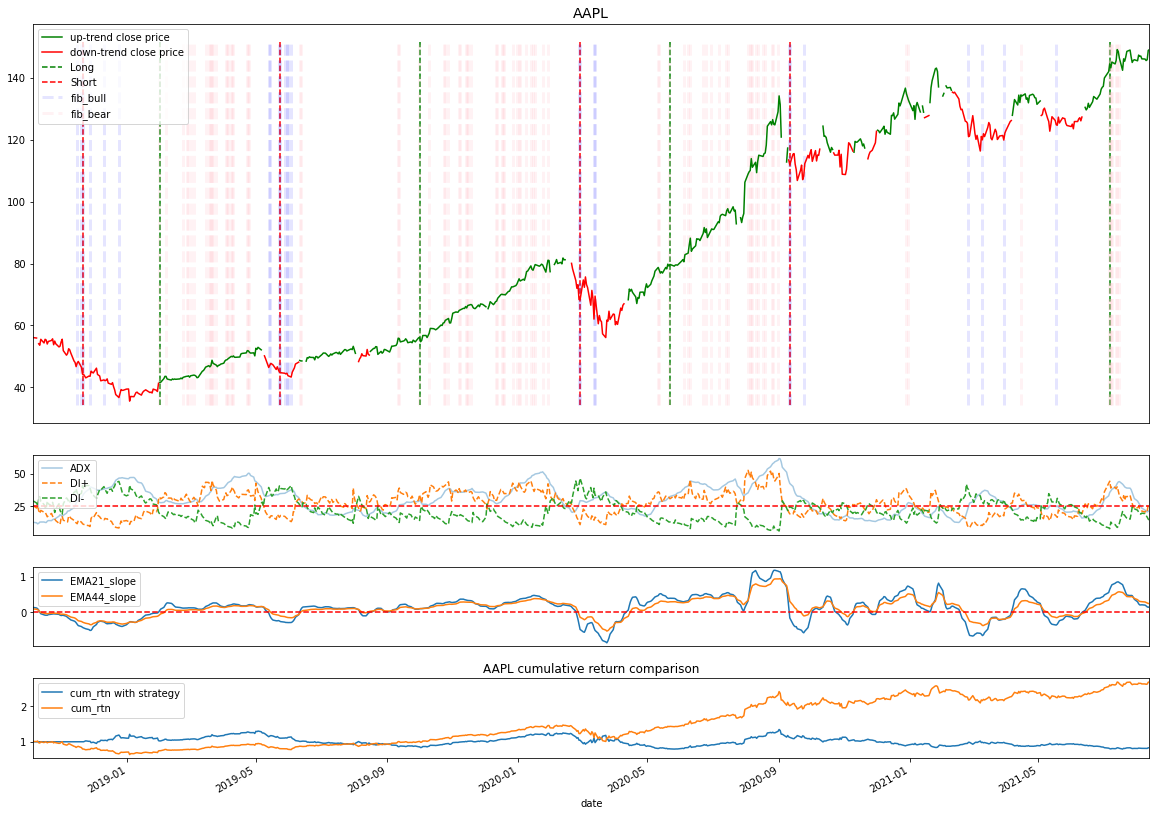

In [19]:
ticker = 'AAPL'
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

today = datetime.today().strftime('%Y-%m-%d')
delta = dateutil.relativedelta.relativedelta(months = 36)
begin = (datetime.today() - delta).strftime('%Y-%m-%d')

stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
{ticker}?from={begin}&to={today}&apikey={fm_key}').json()
stock = pd.DataFrame(stock['historical'])
stock = stock.sort_values('date').reset_index(drop = True)
stock['date'] = pd.to_datetime(stock['date'])

def MA(tp, n):
    ma = tp.rolling(window = n).mean()
    return ma

def EMA(close, n):
    ema = close.ewm(span = n).mean()
    return ema

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def Bounds(tp, sma, n, m):
    std = tp.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

def ADX(stock, n = 14):
    
    stock['hl'] = stock['high'] - stock['low']
    stock['hc'] = abs(stock['high'] - stock['close'].shift())
    stock['lc'] = abs(stock['low'] - stock['close'].shift())
    stock['TR'] = stock[['hl', 'hc', 'lc']].max(axis = 1, skipna = False)
    
    temp = sum(stock.TR.isna())
    stock['sm_tr'] = np.nan
    stock.loc[n-1+temp,'sm_tr'] = stock.TR[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'sm_tr'] = stock.loc[i-1,'sm_tr'] - stock.loc[i-1,'sm_tr']/n + stock.loc[i,'TR']
        
    stock['pos_dm'] = np.where((stock.high-stock.high.shift()) > (stock.low.shift()-stock.low),\
                               stock.high-stock.high.shift(), 0)
    stock['neg_dm'] = np.where((stock.high-stock.high.shift()) < (stock.low.shift()-stock.low),\
                              stock.low.shift()-stock.low, 0)
        
    stock['pos_di'] = np.nan
    temp = sum(stock.pos_dm.isna())
    stock.loc[n-1+temp,'pos_di'] = stock.pos_dm[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'pos_di'] = stock.loc[i-1,'pos_di'] - stock.loc[i-1,'pos_di']/n + stock.loc[i,'pos_dm']
    stock.pos_di = (stock.pos_di / stock.sm_tr) * 100
    
    stock['neg_di'] = np.nan
    temp = sum(stock.neg_dm.isna())
    stock.loc[n-1+temp,'neg_di'] = stock.pos_dm[temp:n-1+temp].sum()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'neg_di'] = stock.loc[i-1,'neg_di'] - stock.loc[i-1,'neg_di']/n + stock.loc[i,'neg_dm']
    stock.neg_di = (stock.neg_di / stock.sm_tr) * 100
    
    stock['dx'] = (abs(stock.pos_di - stock.neg_di) / abs(stock.pos_di + stock.neg_di)) * 100
    
    temp = sum(stock.dx.isna())
    stock.loc[n-1+temp,'ADX'] = stock.dx[temp:n-1+temp].mean()
    for i in range(n+temp, len(stock)):
        stock.loc[i,'ADX'] = (stock.loc[i-1,'ADX'] * (n-1) + stock.loc[i,'dx']) / n

stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
stock['EMA21_slope'] = stock['EMA21'].rolling(8).apply(calc_slope)
stock['EMA44_slope'] = stock['EMA44'].rolling(8).apply(calc_slope)
ADX(stock)
# stock['ADX'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)

stock = stock.dropna()
stock.reset_index(drop = True, inplace = True)

stock['pos'] = np.nan # position for next day
ts = 0 # trading signal
long = [] # long
short = [] # short
exit = []
fib_bull = []
fib_bear = []
for d in range(6,len(stock)-1):
    # downtrend
    if (stock.loc[d+1,'pos_di'] < stock.loc[d+1,'neg_di'])\
    & (stock.loc[d+1,'EMA21_slope'] < 0) & (stock.loc[d+1,'ADX'] > 25):
        # bullish signal
        if (stock.loc[d,'close'] < stock.loc[d-3,'close'] < stock.loc[d-5,'close'] < stock.loc[d-6,'close']):
            fib_bull.append(stock.loc[d,'date'])
            if (stock.loc[d+1,'close'] > stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] > 0):
                #if stock.loc[d+1,'low'] < stock.loc[d+1,'BOLD']: # oversold
                    if ts != 1:
                        long.append(stock.loc[d+1,'date'])
                        ts = 1
            elif (stock.loc[d+1,'close'] < stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] < 0): # bearish
                #if stock.loc[d+1,'high'] > stock.loc[d+1,'BOLU']: # overbought
                    if ts != -1:
                        short.append(stock.loc[d+1,'date'])
                        ts = -1
                        
    # uptrend
    if (stock.loc[d+1,'pos_di'] > stock.loc[d+1,'neg_di'])\
    & (stock.loc[d+1,'EMA21_slope'] > 0) & (stock.loc[d+1,'ADX'] > 25):
        # bearish signal
        if (stock.loc[d,'close'] > stock.loc[d-3,'close'] > stock.loc[d-5,'close'] > stock.loc[d-6,'close']):
            fib_bear.append(stock.loc[d,'date'])
            if (stock.loc[d+1,'close'] < stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] < 0):
                #if stock.loc[d+1,'high'] > stock.loc[d+1,'BOLU']: # overbought
                    if ts != -1:
                        short.append(stock.loc[d+1,'date'])
                        ts = -1
            elif (stock.loc[d+1,'close'] > stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] > 0):
                #if stock.loc[d+1,'low'] < stock.loc[d+1,'BOLD']: # oversold
                    if ts != 1:
                        long.append(stock.loc[d+1,'date'])
                        ts = 1

    stock.loc[d+1,'pos'] = ts

stock = stock.set_index('date')

stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

stock['rtn'] = stock['close'].pct_change()
stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

stock = stock.dropna()

up = []
down = []
for date in stock.index.tolist():
    if (stock.loc[date, 'pos_di'] > stock.loc[date, 'neg_di']) & (stock.loc[date, 'EMA21_slope'] > 0):
        up.append(date)
    else:
        down.append(date)
        
stock['up_close'] = np.where(stock.index.isin(up), stock.close, np.nan)
stock['down_close'] = np.where(stock.index.isin(down), stock.close, np.nan)

plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['axes.xmargin'] = 0
fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 2, 2, 2]})

stock['up_close'].plot(label = 'up-trend close price', ax = axs[0], color = 'green')
stock['down_close'].plot(label = 'down-trend close price', ax = axs[0], color = 'red')
# stock['close'].plot(label = 'Close price', ax = axs[0])
# stock['EMA21'].plot(label = 'EMA_21days', ax = axs[0])
# stock['EMA44'].plot(label = 'EMA_44days', ax = axs[0])
# stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
# stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), min(stock.EMA21))
axs[0].vlines(long, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 1)
axs[0].vlines(short, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 1)
# axs[0].vlines(exit, ymin = ymin, ymax = ymax,\
#               color = 'blue', linestyle = '--', label = 'Exit', alpha = 0.3, lw = 5)
axs[0].vlines(fib_bull, ymin = ymin, ymax = ymax,\
              color = 'blue', linestyle = '--', label = 'fib_bull', alpha = 0.1, lw = 3)
axs[0].vlines(fib_bear, ymin = ymin, ymax = ymax,\
              color = 'pink', linestyle = '--', label = 'fib_bear', alpha = 0.2, lw = 3)

stock['ADX'].plot(label = 'ADX', alpha = 0.4, ax = axs[1])
stock['pos_di'].plot(label = 'DI+', linestyle = '--', ax = axs[1])
stock['neg_di'].plot(label = 'DI-', linestyle = '--', ax = axs[1])
axs[1].axhline(25, color = 'red', linestyle = '--')

stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
axs[2].axhline(0, color = 'red', linestyle = '--')

stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])

axs[0].set(xlabel = '')
axs[1].set(xlabel = '')
axs[2].set(xlabel = '')
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[0].set_title(f'{ticker}', fontsize = 14)
axs[3].set_title(f'{ticker} cumulative return comparison')
plt.show()

In [15]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
stock[['EMA21_slope', 'pos_di', 'neg_di', 'ADX']]

EMA21_slope     pos_di     neg_di        ADX
date                                                    
2018-10-05     0.133661  25.486719  29.065103  12.527246
2018-10-08     0.117748  23.608009  27.531560  12.180460
2018-10-09     0.098272  25.648577  25.336611  11.354132
2018-10-10     0.056104  21.643362  30.328134  11.736740
2018-10-11    -0.001233  19.470549  32.498776  12.689050
2018-10-12    -0.045272  21.793646  28.838161  12.776490
2018-10-15    -0.075393  20.374657  26.382033  12.781610
2018-10-16    -0.085850  20.229368  24.198010  12.506700
2018-10-17    -0.086412  18.838866  23.106822  12.340147
2018-10-18    -0.087518  16.812548  28.947852  13.352939
2018-10-19    -0.070787  17.653974  26.950515  13.887883
2018-10-22    -0.057380  19.414986  25.360956  13.844419
2018-10-23    -0.050106  17.290534  28.012257  14.546018
2018-10-24    -0.048495  16.444949  24.711917  14.941766
2018-10-25    -0.050969  15.193588  20.157911  14.877550
2018-10-26    -0.053299  13.837865  23.200418  15.620443
2018-10-29    -0.062419  11.789080  26.928765  17.297740
2018-10-30    -0.083566  11.025166  21.697190  18.391748
2018-10-31    -0.095443  15.905018  20.008024  17.894112
2018-11-01    -0.088955  17.035993  18.785483  16.964812
2018-11-02    -0.089570  14.207694  26.919245  17.960760
2018-11-05    -0.118324  12.926212  31.524792  19.666465
2018-11-06    -0.149582  12.850850  30.527861  21.172463
2018-11-07    -0.171243  17.465749  28.572398  21.383350
2018-11-08    -0.193458  16.906701  27.554035  21.566519
2018-11-09    -0.219175  15.784847  30.510926  22.298103
2018-11-12    -0.249219  14.064651  35.818418  23.820347
2018-11-13    -0.265249  13.231518  36.115737  25.431311
2018-11-14    -0.298639  12.081504  38.588087  27.351404
2018-11-15    -0.342238  11.434341  35.516045  29.061433
2018-11-16    -0.380238  13.925592  33.458969  29.930122
2018-11-19    -0.407038  12.698004  35.123571  31.141845
2018-11-20    -0.431007  11.387780  40.950410  32.951989
2018-11-21    -0.445516  10.950431  38.304004  34.565079
2018-11-23    -0.470078  10.408832  41.112372  36.352858
2018-11-26    -0.492235   9.881387  41.017122  38.125668
2018-11-27    -0.516633   9.253138  39.240985  39.819414
2018-11-28    -0.512309  15.739101  36.182974  39.787609
2018-11-29    -0.473666  16.532903  34.112005  39.424958
2018-11-30    -0.416799  15.898798  33.582369  39.161603
2018-12-03    -0.349252  20.071147  31.106162  37.904511
2018-12-04    -0.292135  18.135208  33.678744  37.339814
2018-12-06    -0.259129  16.851560  37.898961  37.418568
2018-12-07    -0.255480  15.631515  37.545854  37.689377
2018-12-10    -0.274019  14.445564  40.275246  38.368898
2018-12-11    -0.295722  15.597281  38.071131  38.619361
2018-12-12    -0.316132  15.144204  36.589965  38.821819
2018-12-13    -0.328569  15.296049  35.041474  38.850693
2018-12-14    -0.324782  14.235893  37.832364  39.312668
2018-12-17    -0.318506  13.255237  38.351854  39.978204
2018-12-18    -0.303829  11.622059  36.616643  40.823645
2018-12-19    -0.301824  10.437739  39.345655  42.055341
2018-12-20    -0.312211   9.581228  40.683849  43.471187
2018-12-21    -0.340869   8.626366  43.253817  45.133606
2018-12-24    -0.382691   8.119638  44.313316  46.840383
2018-12-26    -0.400332  13.547908  39.075439  46.959634
2018-12-27    -0.403789  11.962128  35.981313  47.183875
2018-12-28    -0.392901  13.423891  34.343746  46.941815
2018-12-31    -0.356752  13.922915  33.066004  46.498798
2019-01-02    -0.305404  13.145496  33.939031  46.331894
2019-01-03    -0.278317  10.889159  41.299536  47.184619
2019-01-04    -0.268721  13.200284  38.459466  47.306810
2019-01-07    -0.283811  13.080056  37.190607  47.353571
2019-01-08    -0.291415  15.953275  35.515306  46.686010
2019-01-09    -0.286373  18.219508  33.470061  45.458732
2019-01-10    -0.267175  16.847578  32.202501  44.447722
2019-01-11    -0.232977  16.012615  31.263615  43.577123
2019-01-14    -0.186090  15.365824  33.013796  43.070051
2019-01-15    -0.15587

In [16]:
short

[Timestamp('2018-11-20 00:00:00'),
 Timestamp('2019-05-24 00:00:00'),
 Timestamp('2020-02-28 00:00:00'),
 Timestamp('2020-09-11 00:00:00')]